# Subsample master light curves 

* subsample using np.interp1d from `dp2/sim_master`   using real cadences of combined SDSS,PS1 light curves.
or simulated cadences of LSST and ZTF
* add the median of each real light curve 
* add photometric noise corresponding to real light curves (SDSS,PS1), or simulated magnitude-dependent error curves (LSST, ZTF)
* store in `dp2/sim_subsampled/`

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
import celerite
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [86]:
def calc_lsst_error(m, gamma=0.039 , sigma_sys=0.005, m5=24.7):
    # Calculate LSST error based on the magnitude of the observed light curve ...
    # we use magnitude-dependent single-visit 
    # formula for r-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
     # mag 
    #sigma_sys = 0.005
    #gamma = 0.039 
    #m5 = 24.7
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma

# Note : for LSST, use gamma=0.039 , sigma_sys=0.005, m5=24.7
# and for ZTF, use gamma=0.025, sigma_sys = 0.005, m5 = 20.8
# ( based on the plot of best median mag vs best mag rms in g-band )

   Note : after the new `Crossmatch_...` and `Combine_all....` , it would be better to use as realDir  `../dp2/real_combined_r/`

In [87]:
# combined light curves
realDir = '../data_products/Combined_LC/'
realLcs =  os.listdir(realDir)


t_sim  = np.loadtxt('../dp2/t_master.txt')
mjd_lsst = np.loadtxt('../dp2/mjd_lsst_ten_years_500_epochs.txt')
mjd_ztf = np.loadtxt('../dp2/mjd_ztf_2018_240_epochs.txt')

for i in range(len(realLcs)):
    if (i % 1000) == 0 : 
        print(i)
    # Load the i-th master light curve
    simDir = '../dp2/sim_master/'
    y_sim = np.loadtxt(simDir+str(i).zfill(4)+'.txt')

    lc_sim = Table([y_sim, t_sim], names=['mag_true', 'mjd'])

    # Load the i-th combined real light curve 
    lcname = realLcs[i]
    lc_comb = Table.read(realDir+lcname, format='ascii')
    lc_comb.sort('mjd') # sort by mjd .... 
    # keep only the first row if there are two rows that for 
    # some reason have the same MJD ...
    lc_comb = unique(lc_comb, keys='mjd', keep='first')
    
    # keep survey information 
    survey = np.append(np.asarray(lc_comb['originSurvey']), 
             np.repeat('ztf',len(mjd_ztf)))
    survey = np.append(survey, np.repeat('lsst', len(mjd_lsst)))

    # add info on band of origin 
    band = np.append(np.asarray(lc_comb['originBand']), 
                     np.repeat('r', len(mjd_ztf)))
    band = np.append(band, np.repeat('r', len(mjd_lsst)))


    # add simulated ZTF and LSST cadence 
    mjd_comb = np.append(np.asarray(lc_comb['mjd']),  mjd_ztf)
    mjd_comb = np.append(mjd_comb, mjd_lsst)


    # subsample at the SDSS-PS1-PTF-CRTS-ZTF-LSST combined 
    # cadences -  sample at those times using  np.interp1d 
    y_true = np.interp(mjd_comb, lc_sim['mjd'], lc_sim['mag_true'])

    # add the median magnitude of the combined light curve to these sampled points
    y_true += np.mean(lc_comb['mag']) 

    # simulate ZTF and LSST errors given the magnitudes at these times
    #ztf_error = 1.5* calc_lsst_error(y_true[survey =='ztf'])
    ztf_error = calc_lsst_error(y_true[survey =='ztf'],
                                gamma=0.025, sigma_sys = 0.005, m5 = 20.8)
    # note : 
    lsst_error = calc_lsst_error(y_true[survey =='lsst'])

    y_err = np.append(np.asarray(lc_comb['magerr']),ztf_error)
    y_err = np.append(y_err, lsst_error)

    # add the photometric noise corresponding to epochal errors 
    y_obs = y_true +  y_err * np.random.normal(loc=0,scale=1,size=len(y_true))

    # store as sim_subsample/  , saving as : 
    # mjd   |  mag_true   |  mag_obs    | error   |   survey    

    lc_obs = Table([mjd_comb, y_true, y_obs, y_err, band, survey], 
                      names=['mjd','magtrue', 'magobs', 'magerr',
                             'originBand', 'originSurvey'])
    obsDir = '../dp2/sim_subsampled2/'
    lc_obs.write(obsDir+lcname, format='ascii', overwrite=True)

0
1000
2000
3000
4000
5000
6000


In [88]:
lc_obs

mjd,magtrue,magobs,magerr,originBand,originSurvey
float64,float64,float64,float64,str1,str4
51075.294315,19.084997549656876,19.092022161763985,0.012,r,sdss
52196.294828,19.005695026838048,19.032507681305002,0.014,r,sdss
52197.307936,19.013581838002295,18.99003759962086,0.015,r,sdss
52225.158124,19.03471411369723,19.04920707124844,0.014,r,sdss
52231.193909,19.03944314545596,19.030649553323133,0.013,r,sdss
52253.180079,19.03831400082189,19.026503974404978,0.02,r,sdss
52557.301911,19.088424252997076,19.085994297266048,0.014,r,sdss
52578.197994,19.107170987487645,19.09976027125369,0.013,r,sdss
52908.276477,18.937516678860295,18.93554689477185,0.014,r,sdss


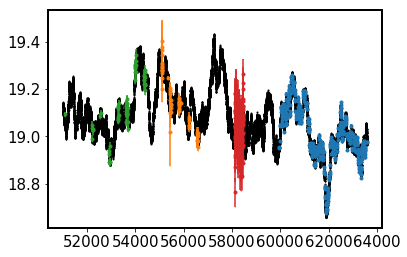

In [89]:
# this illustrates which parts of simulated light curve are 
# 'observed'  at real cadences ...
%matplotlib inline
plt.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_comb['mag']) , c='k',
           s=1)
for s in ['lsst', 'ps1',  'sdss', 'ztf']:
    m = survey == s
    plt.errorbar(mjd_comb[m], y_obs[m], y_err[m], fmt=".", capsize=0.2,)
#plt.xlim(52000,53000)

In [3]:
# plot the true signal,  and the subsampling , to show what is being saved...
t_sim  = np.loadtxt('../dp2/t_master.txt')
realDir = '../data_products/Combined_LC/'
realLcs =  os.listdir(realDir)

i = 1
# Load the i-th master light curve
simDir = '../dp2/sim_master/'
y_sim = np.loadtxt(simDir+str(i).zfill(4)+'.txt')

lc_sim = Table([y_sim, t_sim], names=['mag_true', 'mjd'])

obsDir = '../dp2/sim_subsampled2/'
lcname = realLcs[i]
lc_obs = Table.read(obsDir+lcname, format='ascii',)

In [7]:
np.unique(lc_obs['originSurvey'])

crts
lsst
ps1
ptf
sdss
ztf


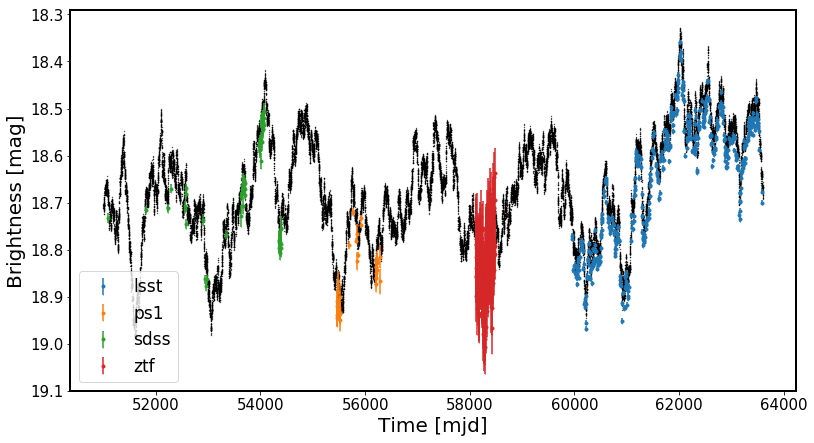

In [92]:
fig,ax = plt.subplots(1,1,figsize=(13,7))
ax.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_obs['magobs']), s=0.1, c='k',
           label='')
for s in ['lsst', 'ps1',  'sdss', 'ztf']:
    m = lc_obs['originSurvey'] == s
    ax.errorbar(lc_obs['mjd'][m], lc_obs['magobs'][m], 
                 lc_obs['magerr'][m], fmt=".", capsize=0.2, label=s)
ax.legend(loc='lower left', fontsize=17)
ax.invert_yaxis()
ax.set_ylabel('Brightness [mag]')
ax.set_xlabel('Time [mjd]')
plt.savefig('Simulated_DRW-'+str(i).zfill(4)+'_sampled-'+\
           lcname[:-4]+'.png', bbox_inches='tight')

Illustration of subsampling the true DRW signal (black), at cadences corresponding to a combined light curve. The original DRW signal is modeled with mean around 0, so the offset equal to the mean of the combined light curve is added.  At each sampled epoch, a photometric Gaussian noise is added, with variance representing the uncertainty of epochal measurement. For ZTF and LSST simulated cadence, error is modeled after the simulated brightness (magnitude-dependent error model). 

Plot  the error distribution for simulated combined r-band light curves ... 

In [99]:
np.unique(lc_obs['originSurvey'])

crts
lsst
ps1
ptf
sdss
ztf


In [100]:
obsDir = '../dp2/sim_subsampled2/'
stats = {}
segs = ['lsst', 'ps1',  'sdss', 'ztf', 'ptf']
for s in segs: 
    stats[s] = {'lcname':[], 'medErr':[], 'meanErr':[], 'medMag':[] }
    
for i in range(len(realLcs)) : 
    lcname = realLcs[i]
    lc_obs = Table.read(obsDir+lcname, format='ascii',)
    for s in segs : 
        m = lc_obs['originSurvey'] == s
        lc = lc_obs[m]
        stats[s]['lcname'].append(lcname)
        stats[s]['medErr'].append(np.median(lc['magerr']))
        stats[s]['meanErr'].append(np.mean(lc['magerr']))
        stats[s]['medMag'].append(np.median(lc['magobs']))
    if i % 1000 == 0 : print(i)
fname = 'sim_subsampled2_stats'
np.save(fname, stats)

0


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1000
2000
3000


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3115: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4000
5000
6000


(the above took ~5 mins to run )

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


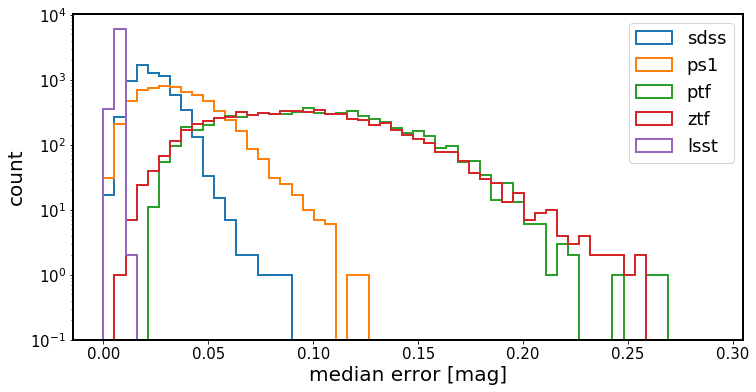

In [3]:
fname = 'sim_subsampled2_stats.npy'
r = np.load(fname).item()

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(12,6))
for seg in ['sdss', 'ps1','ptf','ztf', 'lsst']:#list(r.keys()):
    #ax.hist(sall['medErr_'+seg], range = (0,0.5),lw=2, label=seg, bins=45,
    #       histtype='step')
    ax.hist(r[seg]['medErr'],lw=2, range = (0,0.29), label=seg, bins=55,
           histtype='step', density=False, log=True)
ax.legend(fontsize=18)
ax.set_xlabel('median error [mag]')
ax.set_ylabel('count')
plt.savefig('sim_subsampled2_stats_error_log.png', bbox_inches='tight')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


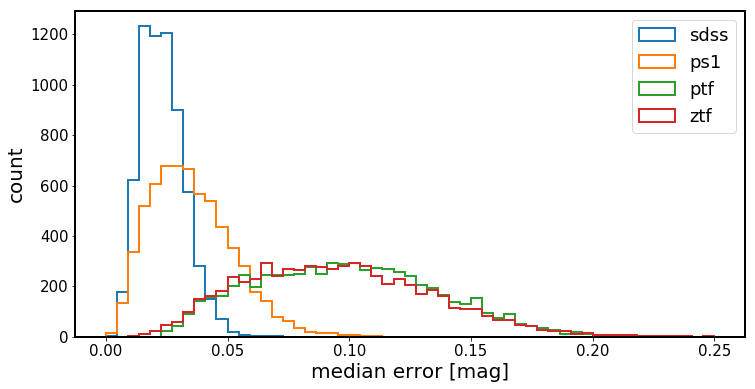

In [4]:
fname = 'sim_subsampled2_stats.npy'
r = np.load(fname).item()

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(12,6))
for seg in ['sdss', 'ps1','ptf','ztf',]:#list(r.keys()):
    #ax.hist(sall['medErr_'+seg], range = (0,0.5),lw=2, label=seg, bins=45,
    #       histtype='step')
    ax.hist(r[seg]['medErr'],lw=2, range = (0,0.25), label=seg, bins=55,
           histtype='step', density=False, log=False)
ax.legend(fontsize=18)
ax.set_xlabel('median error [mag]')
ax.set_ylabel('count')
plt.savefig('sim_subsampled2_stats_error_lin.png', bbox_inches='tight')